In [1]:
%reload_ext jupyter_black

**Key takeaways from the dataset**

* Some articles have no image
* Some customers don't buy anything
* The complete transaction data has 31 788 325 rows, just short of 32 million (!!)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Tuple
from types import NoneType
import random, shutil, os, itertools, black, jupyter_black

jupyter_black.load()

## Sampling methods

We need to be able to pull out realistic samples of the dataset. To do this, we first sample $n$ customers at random and include every transaction that they have done - these are the positive labels. In addition, we want to obtain additional transactions that are not related to the customers in the sample, working as a negative label. We implement this by saying that $k$% of the data are true labels, defaulting $k=10$%. Lastly, we pull out the article IDs in all the transactions and obtain the images for said article.

In [3]:
def naive_csv_sampler(
    csv_path: str,
    sample_size: int,
    num_records: int | NoneType = None,
    header: str | NoneType = "infer",
) -> pd.DataFrame:
    """Read samples of rows from csv file

    Args:
        csv_path (str): Path to file including file extensions
        sample_size (int): Number of rows to sample
        num_records (int | NoneType, optional): Total records in file, defaults to None. If None, the file will be scanned (costly)
        header (str | NoneType, optional): 'header'-parameter for pandas, defaults to 'infer'. Set to None if file has no header.

    Returns:
        pd.DataFrame: Dataframe with sampled entries (and potentially header)
    """
    if num_records is None:
        num_records = newlines_in_csv(csv_path)
    indices_skip = sorted(
        random.sample(range(1, num_records + 1), num_records - sample_size)
    )
    return pd.read_csv(csv_path, skiprows=indices_skip, header=header)


def newlines_in_csv(csv_path: str, chunk_size: int = 1024) -> int:
    """Counts number of newlines in csv file without loading entire file to memory.
    The number of newlines is the same as number of rows assuming,
        * EITHER csv has a header and last entry does not end with newline
        * OR csv does not have a header, but last entry ends with newline
        * ALWAYS data does not have any nested newline madness
    Originally from orlp, https://stackoverflow.com/a/64744699

    Args:
        csv_path (str): Path of csv file
        chunk_size (int, optional): How many KB to process at at a time. Defaults to 1024 = 1 MB.

    Returns:
        int: Number of newlines
    """
    chunk = chunk_size**2
    f = np.memmap(csv_path)
    number_newlines = sum(
        np.sum(f[i : i + chunk] == ord("\n")) for i in range(0, len(f), chunk)
    )
    del f
    return number_newlines

In [4]:
def copy_img_from_article(df: pd.DataFrame, outpath):
    for id in df["article_id"]:
        id0 = "0" + str(id)
        img_path = f"./dataset/images/{id0[:3]}/{id0}.jpg"
        if not os.path.isfile(img_path):
            continue  # ID has no image (happens for some cases)
        out_dir = f"./{outpath}/images/{id0[:3]}/"
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
            shutil.copy(img_path, out_dir)


# copy_img_from_article(df_art, "dataset_sample")

## Data loading and preprocessing

In [5]:
# Cleaning up the datasets
from typing import Iterable


def load_min_data(filename: str | Iterable):
    dfs = []
    if isinstance(filename, str):
        filename = [filename]
    for fn in filename:
        df = pd.read_csv(fn)
        # All min-datasets have an index column which has to be dropped:
        dfs.append(df.drop(df.columns[0], axis=1))
    return dfs


def clean_customer_data(df):
    # df = df.drop("FN", axis=1) # I they're not exactly equal
    df.loc[
        ~df["fashion_news_frequency"].isin(["Regularly", "Monthly"]),
        "fashion_news_frequency",
    ] = "None"
    return df

Number of rows in complete transactions csv:

In [6]:
newlines_in_csv("dataset/transactions_train.csv")

31788325

In [7]:
# Look at what data we actually have

transactions_full = pd.read_csv("dataset/transactions_train.csv")
customers_full = pd.read_csv("dataset/customers.csv")
articles_full = pd.read_csv("dataset/articles.csv")

In [8]:
# Column types
print("Transactions: ", ", ".join(transactions_full.columns), end="\n---\n")
print("Customers:", ", ".join(customers_full.columns), end="\n---\n")
print("Articles:", ", ".join(articles_full.columns), end="\n---\n")

Transactions:  t_dat, customer_id, article_id, price, sales_channel_id
---
Customers: customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code
---
Articles: article_id, product_code, prod_name, product_type_no, product_type_name, product_group_name, graphical_appearance_no, graphical_appearance_name, colour_group_code, colour_group_name, perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name, department_no, department_name, index_code, index_name, index_group_no, index_group_name, section_no, section_name, garment_group_no, garment_group_name, detail_desc
---


**Customer data**

In [9]:
# What values do the categorical columns take?
for col in ["FN", "Active", "club_member_status", "fashion_news_frequency"]:
    print(col, customers_full[col].unique())

FN [nan  1.]
Active [nan  1.]
club_member_status ['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']
fashion_news_frequency ['NONE' 'Regularly' nan 'Monthly' 'None']


In [10]:
# NaN-data of customers
## Several customers have NaN-fields, let's have a look at how many..

num_customers = customers_full.size
res = {"Column": [], "Number NaN": [], "Portion of entries NaN": []}
for col in customers_full.columns:
    num_na = customers_full[pd.isna(customers_full[col])].size
    res["Column"].append(col)
    res["Number NaN"].append(num_na)
    res["Portion of entries NaN"].append(round(num_na / num_customers, 4))
print(num_customers)
pd.DataFrame(res)

9603860


,Column,Number NaN,Portion of entries NaN
0,customer_id,0,0.0000
1,FN,6265350,0.6524
2,Active,6353032,0.6615
3,club_member_status,42434,0.0044
4,fashion_news_frequency,112063,0.0117
5,age,111027,0.0116
6,postal_code,0,0.0000


We see that about 1.16% of ages are NaN. Thus, it should be safe to omit these entries, whereas for *FN* and *Active*, over half of the entries are NaN. This is since NaN here represents the negative in a binary variable, where 1 indicates `True` and NaN indicates `False`.

In [11]:
# Variation of ages in ages
customers_full.describe()["age"][1:]

mean    36.386965
std     14.313628
min     16.000000
25%     24.000000
50%     32.000000
75%     49.000000
max     99.000000
Name: age, dtype: float64

The total mean of ages are 36, but is the distribution of ages unimodal?

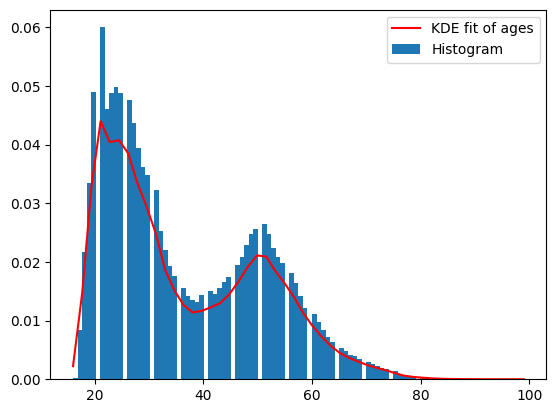

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# plt.hist(customers_full["age"], bins=50, alpha=0.7)
# plt.title("Distribution of ages of customers")
samples = customers_full["age"].dropna()
h, e = np.histogram(samples, bins=100, density=True)
x = np.linspace(e.min(), e.max())

kde_fit = gaussian_kde(samples)
plt.plot(x, kde_fit.pdf(x), "r", label="KDE fit of ages")

plt.bar(e[:-1], h, width=np.diff(e), ec=None, align="edge", label="Histogram")
plt.legend()
plt.show()

We see that the ages have a multimodal distribution, where the first peak is for the early 20's and the next peak is around 50. Multiple modes may introduce issues with local minima in the machine learning algorithm.

## Exploring the article data

From the previous output showing the columns in the datasets, we notice that all variables are indexed with a specific ID/group number;

| Index                      | Value                        |
|----------------------------|------------------------------|
| product_code               | prod_name                    |
| product_type_no            | product_type_name            |
|                            | product_group_name           |
| graphical_appearance_no    | graphical_appearance_name    |
| colour_group_code          | colour_group_name            |
| perceived_colour_value_id  | perceived_colour_value_name  |
| perceived_colour_master_id | perceived_colour_master_name |
| department_no              | department_name              |
| index_code                 | index_name                   |
| index_group_no             | index_group_name             |
| section_no                 | section_name                 |
| garment_group_no           | garment_group_name           |

There are also some clear hierarchies within these column types

In [13]:
articles_full.groupby(["index_group_name", "index_name"]).count()["article_id"]

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

In [14]:
articles_full.groupby(["product_group_name", "product_type_name"]).count()["article_id"]

product_group_name   product_type_name
Accessories          Accessories set         7
                     Alice band              6
                     Baby Bib                3
                     Bag                  1280
                     Beanie                 56
                                          ... 
Underwear            Underwear corset        7
                     Underwear set          47
Underwear/nightwear  Sleep Bag               6
                     Sleeping sack          48
Unknown              Unknown               121
Name: article_id, Length: 132, dtype: int64

In [ ]:
# Exploring the article data
for col in (
    "department_name",
    "index_name",
    "index_group_name",
    "section_name",
    "garment_group_name",
):
    print(articles_full.groupby(col).count()["article_id"].sort_values(ascending=False))

department_name
Jersey                             4604
Knitwear                           3503
Trouser                            2655
Blouse                             2362
Dress                              2087
                                   ... 
Accessories Other                     1
Kids Boy License                      1
Jersey inactive from S.6              1
Woven bottoms inactive from S.7       1
Shirt Extended inactive from s1       1
Name: article_id, Length: 250, dtype: int64
index_name
Ladieswear                        26001
Divided                           15149
Menswear                          12553
Children Sizes 92-140             12007
Children Sizes 134-170             9214
Baby Sizes 50-98                   8875
Ladies Accessories                 6961
Lingeries/Tights                   6775
Children Accessories, Swimwear     4615
Sport                              3392
Name: article_id, dtype: int64
index_group_name
Ladieswear       39737
Baby/Children    3

In [57]:
articles_full["index_group_name"].unique()
cmap = {
    k: v
    for k, v in zip(
        articles_full["index_group_name"].unique(), ("r", "b", "g", "y", "p")
    )
}
cmap

{'Ladieswear': 'r',
 'Baby/Children': 'b',
 'Menswear': 'g',
 'Sport': 'y',
 'Divided': 'p'}

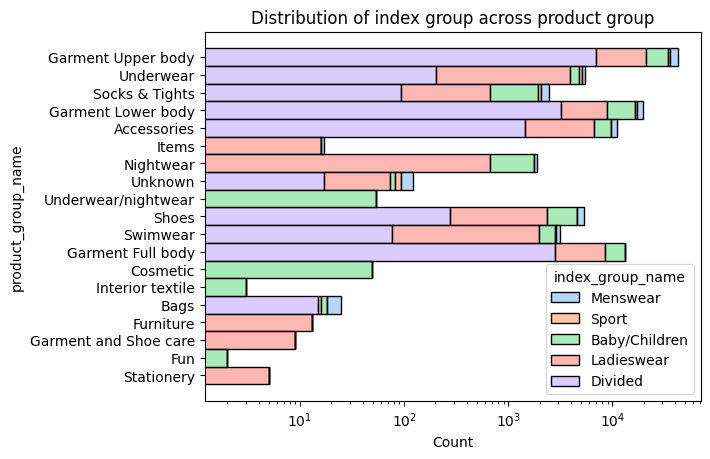

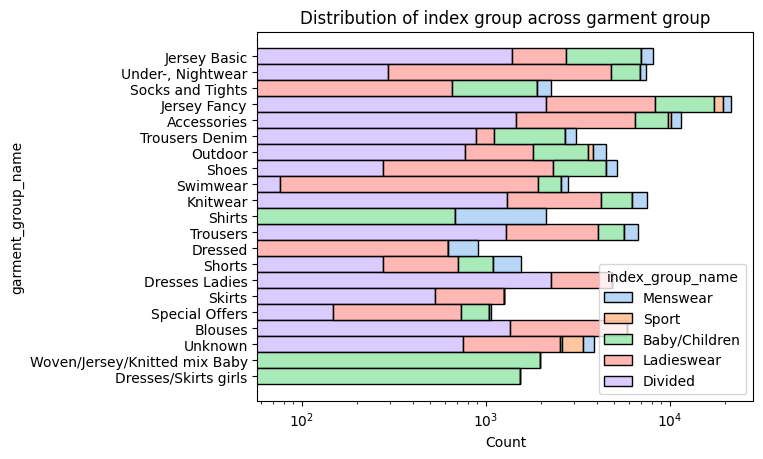

In [107]:
# Let's see how the indicides are spread across
def barplot_articles_on_index(df: pd.DataFrame, y: str):
    import seaborn

    plt.xscale("log")
    plt.title(f"Distribution of index group across {' '.join(y.split('_')[:-1])}")
    seaborn.histplot(
        data=df,
        y=y,
        hue="index_group_name",
        multiple="stack",
        palette="pastel",
        hue_order=["Menswear", "Sport", "Baby/Children", "Ladieswear", "Divided"],
    )
    plt.show()


barplot_articles_on_index(articles_full, "product_group_name")
barplot_articles_on_index(articles_full, "garment_group_name")